In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# https://www.youtube.com/watch?v=CbTU92pbDKw

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
code = 'SSGC'
filename = lambda x: f'/content/drive/MyDrive/stockdata/{x}.csv'
read = filename(code)

df = pd.read_csv(read,delimiter='\t',header=None)
df.columns = ['Date','Open','High','Low','Close','Volume']
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df.set_index('Date',inplace=True)
df = df[['Close']]

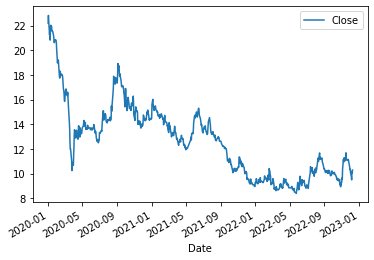

In [116]:
df.plot()

In [117]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [118]:
def df_to_ds(df,n=3):
    df = pd.DataFrame({
        'Date': df.index,
        'Close': df['Close'].values
    })
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.pop('index')
    dates = []
    X = []
    Y = []
    for i in range(n,len(df)):
        sub_df = df.loc[i-n:i]
        values = sub_df['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        date = sub_df.iloc[-1]['Date'].date()
        dates.append(date)
        X.append(x)
        Y.append(y)
        try:
            df.iloc[i+1]
        except:
            break

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df.dropna()

# Start day second time around: '2021-03-25'
windowed_df = df_to_ds(df)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-01-06,22.19,22.82,22.35,21.24
1,2020-01-07,22.82,22.35,21.24,21.72
2,2020-01-08,22.35,21.24,21.72,20.82
3,2020-01-09,21.24,21.72,20.82,21.83
4,2020-01-10,21.72,20.82,21.83,22.02
...,...,...,...,...,...
723,2022-12-05,10.34,10.35,10.10,9.77
724,2022-12-06,10.35,10.10,9.77,9.50
725,2022-12-07,10.10,9.77,9.50,10.19
726,2022-12-08,9.77,9.50,10.19,10.03


In [119]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((728,), (728, 3, 1), (728,))

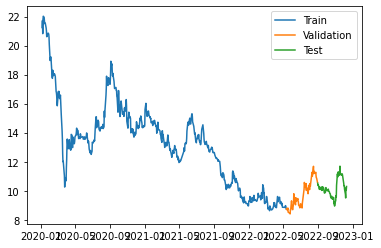

In [120]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [121]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['mean_squared_error']
)


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [123]:
np.mean(history.history.get('mean_squared_error'))

3.252472173795104

19/19 [==============================] - 0s 2ms/step


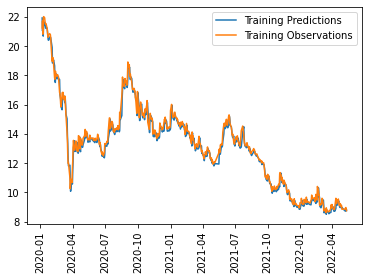

In [124]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 3ms/step


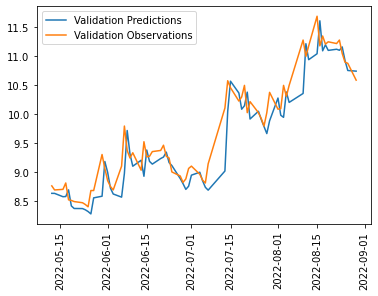

In [125]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 3ms/step


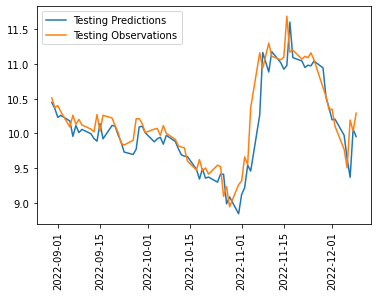

In [126]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

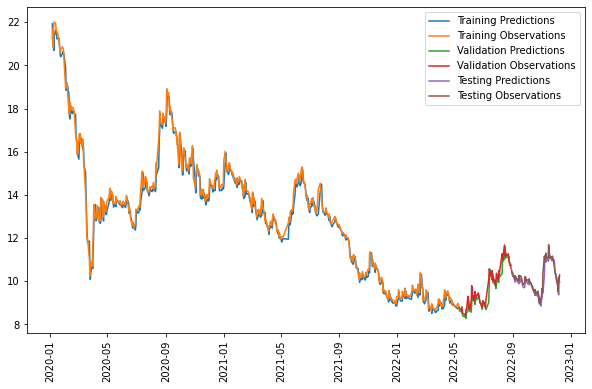

In [127]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])